# `scri` Tutorial
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scri
import quaternion
from spherical_functions import LM_index as lm # for easily accessing mode data
import spherical_functions
from mpl_toolkits import mplot3d
from matplotlib import animation
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

# This is the band-aid until the Numba bug is fixed:
#from numba.errors import NumbaWarning, NumbaDeprecationWarning, NumbaPendingDeprecationWarning
#import warnings
#warnings.simplefilter('ignore', category=NumbaWarning)
#warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
#warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

To access the documentation for any function or object in `scri`, you can call `help(...)` on it.

The basic object in `scri` is the `WaveformModes` object, which stores the coefficients of a waveform
that has been expanded in spin-weighted spherical harmonics (SWSHs). 

In [2]:
help(scri.WaveformModes)

Help on class WaveformModes in module scri.waveform_modes:

class WaveformModes(scri.waveform_base.WaveformBase)
 |  WaveformModes(*args, **kwargs)
 |  
 |  Object containing time, frame, and data, along with related information
 |  
 |  This object collects all the data needed to manipulate time-series of spin-weighted spherical-harmonic modes of
 |  gravitational waves, as well as a few useful informational members.  Various methods exist to manipulate the data
 |  and extract important information.
 |  
 |  As much as possible, completeness of modes is enforced -- meaning that if any (ell,m) mode with a given ell is
 |  included in the data, all modes with abs(m)<=ell must also be included.  The data are stored as complex numbers,
 |  and assumed to be in standard order corresponding to
 |  
 |      [f(ell,m) for ell in range(ell_min, ell_max+1) for m in range(-ell,ell+1)]
 |  
 |  There is no automated check that can be done to assure that the order is correct.  (Precession breaks 

Let's start by importing a waveform from the [SXS Catalog](https://data.black-holes.org/waveforms/catalog.html). Pick any simulation and download one of the `rhOverM_Asymptotic_GeometricUnits_COM.h5` files. Each of these HDF5 files has an interal directory storing the data.

In [43]:
#path = "/path/to/rhOverM_Asymptotic_GeometricUnits_COM.h5"
path = "/Users/isaaclegred/qnm-fitting/GetData/SXS_BBH_0305/Lev3/rhOverM_Asymptotic_GeometricUnits_COM.h5"
h = scri.SpEC.read_from_h5(path+"/Extrapolated_N4.dir")

We can access the time array of the waveform by calling `h.t`. The mode information, called by `h.data`, 
returns a numpy array with dimensions: (number of timesteps, number of modes).

You can easily access a mode with the spherical_functions.LM_index function. 

Let's make a plot of the dominant (2,2) mode:

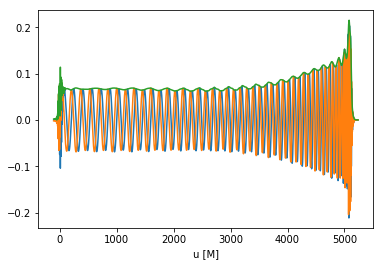

In [4]:
l, m = 2, 2
plt.plot(h.t, np.real(h.data[:, lm(l, m, h.ell_min)]))
plt.plot(h.t, np.imag(h.data[:, lm(l, m, h.ell_min)]))
plt.plot(h.t,  np.abs(h.data[:, lm(l, m, h.ell_min)]))
val= np.max(np.abs(h.data[:, lm(l, m, h.ell_min)]))
frame  = np.where(np.abs(h.data[:, lm(l, m, h.ell_min)]) == val)
plt.xlabel("u [M]")
plt.show()

We can also represent the waveform as points on a sphere, instead of as modes:

In [5]:
h_grid = h.copy()
h_grid.to_grid();
h_rot_grid = h.copy()
h_rot_grid.rotate_decomposition_basis(quaternion.quaternion(0,.1,.4,0));


In [6]:
print(h_grid.data)
print(h_rot_grid.data)


[[-7.50602258e-05+2.00784040e-03j  1.06287914e-04+1.46244519e-04j
   1.12031055e-04+2.10309894e-06j ... -4.91099103e-06-2.88728532e-06j
   7.29780299e-06-1.55557340e-05j -6.09423489e-07+6.18112938e-07j]
 [-9.63185553e-05+2.00971468e-03j  3.09420213e-05+7.16271346e-05j
   1.25043386e-04+3.57026631e-06j ... -2.53261845e-06-3.74331151e-06j
   8.46373912e-06-9.74350613e-06j -7.09510887e-07-3.12567305e-07j]
 [-1.17257910e-04+2.01787988e-03j -4.21333790e-05-2.67961683e-05j
   1.34870846e-04+5.63328084e-06j ...  1.47870710e-06-3.18401876e-06j
   7.63501785e-06+2.67989357e-07j -5.45521372e-07-1.39881020e-06j]
 ...
 [-2.17218563e-05+2.61892929e-05j  3.77978304e-05-6.50830683e-06j
   1.06641640e-04+7.67925936e-07j ...  1.14683870e-07-1.06535662e-07j
   1.47573007e-08-2.90312411e-07j -6.11313922e-08-5.96064238e-07j]
 [-2.24942972e-05+2.48440757e-05j  3.80761260e-05-5.93951923e-06j
   1.06530060e-04+7.75964060e-07j ...  1.13839695e-07-1.06131762e-07j
   1.49565072e-08-2.89794030e-07j -6.23184392e-

---
## Changing Frames

We can pick a different frame in which to represent our waveform. There are three different frames that `scri` supports:
* Inertial
* Coprecessing - The frame aligned to the orbital angular momentum vector
* Corotating - The frame in which removes all rotational dynamics

Calling `h.frame_type_string` will report which frame the `WaveformModes` is currently in. 

In [7]:
# Get the waveform in the coprecessing frame
h_coprec = h.copy()
h_coprec.to_coprecessing_frame();

# Get the waveform in the corotating frame
h_corot = h.copy()
h_corot.to_corotating_frame();

Let's make plots of the (2,2) mode waveform in the different frames:

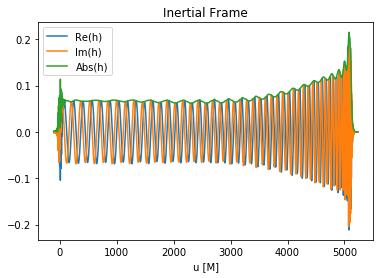

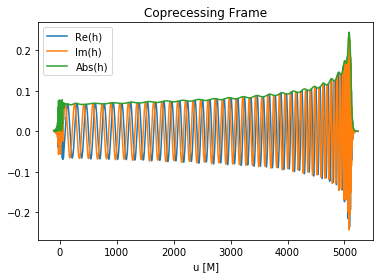

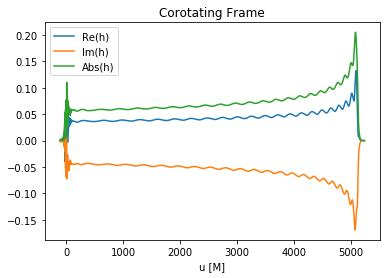

In [8]:
l, m = 2, 2
for WM in [h, h_coprec, h_corot]:
    plt.plot(WM.t, np.real(WM.data[:, lm(l, m, h.ell_min)]), label='Re(h)')
    plt.plot(WM.t, np.imag(WM.data[:, lm(l, m, h.ell_min)]), label='Im(h)')
    plt.plot(WM.t,  np.abs(WM.data[:, lm(l, m, h.ell_min)]), label='Abs(h)')
    plt.xlabel("u [M]")
    plt.title(WM.frame_type_string+" Frame")
    plt.legend()
    plt.show()

In [9]:
frame
WM.t
h.data

array([[-7.50602258e-05+2.00784040e-03j,  1.06287914e-04+1.46244519e-04j,
         1.12031055e-04+2.10309894e-06j, ...,
        -4.91099103e-06-2.88728532e-06j,  7.29780299e-06-1.55557340e-05j,
        -6.09423489e-07+6.18112938e-07j],
       [-9.63185553e-05+2.00971468e-03j,  3.09420213e-05+7.16271346e-05j,
         1.25043386e-04+3.57026631e-06j, ...,
        -2.53261845e-06-3.74331151e-06j,  8.46373912e-06-9.74350613e-06j,
        -7.09510887e-07-3.12567305e-07j],
       [-1.17257910e-04+2.01787988e-03j, -4.21333790e-05-2.67961683e-05j,
         1.34870846e-04+5.63328084e-06j, ...,
         1.47870710e-06-3.18401876e-06j,  7.63501785e-06+2.67989357e-07j,
        -5.45521372e-07-1.39881020e-06j],
       ...,
       [-2.17218563e-05+2.61892929e-05j,  3.77978304e-05-6.50830683e-06j,
         1.06641640e-04+7.67925936e-07j, ...,
         1.14683870e-07-1.06535662e-07j,  1.47573007e-08-2.90312411e-07j,
        -6.11313922e-08-5.96064238e-07j],
       [-2.24942972e-05+2.48440757e-05j,  3.

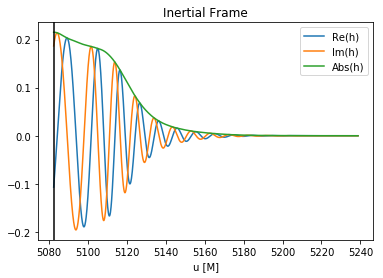

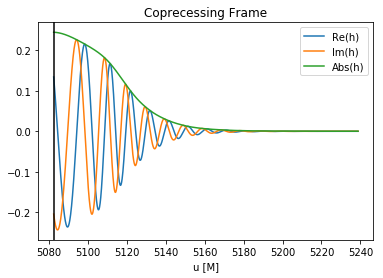

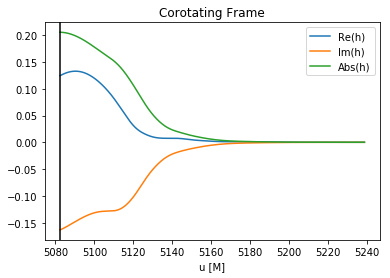

In [10]:
start_frame = frame[0][0] 
max_frame = frame[0][0]
l, m = 2,2
for WM in [h, h_coprec, h_corot]:
    plt.plot(WM.t[start_frame:], np.real(WM.data[:, lm(l, m, h.ell_min)])[start_frame:], label='Re(h)')
    plt.plot(WM.t[start_frame:], np.imag(WM.data[:, lm(l, m, h.ell_min)])[start_frame:], label='Im(h)')
    plt.plot(WM.t[start_frame:],  np.abs(WM.data[:, lm(l, m, h.ell_min)])[start_frame:], label='Abs(h)')
    plt.xlabel("u [M]")
    plt.axvline(WM.t[max_frame], color="k")
    #plt.plot(h.t[start_frame:], quaternion.as_float_array(h_coprec.frame)[start_frame:,0], label = r"$\cos( \alpha/2)$")
    plt.title(WM.frame_type_string+" Frame")
    plt.legend()
    plt.show()

When we go into a different frame, the `WaveformModes` object will store the array of quaternions needed to get into that frame. This allows us to transform back into the inertial frame. This also is helpful if we are interested in the dynams of the system.

Calling `h_corot.frame` will give the array of quaternions. We can also use functions in the `quaternion` python module to view this data in a number of different ways:
* quaternion.as_euler_angles
* quaternion.as_float_array
* quaternion.as_rotation_matrix
* quaternion.as_rotation_vector
* quaternion.as_spherical_coords

In [11]:
((h_coprec.frame[frame[0][0] - 700])*quaternion.z*np.conjugate(h_coprec.frame[frame[0][0] - 700])).imag
k = quaternion.z


In [12]:
v = np.array([0.0322711539692, 0.12081275417, 0.783021732156])
def norm(v) : return np.sqrt(sum(v**2))
v/norm(v)

array([0.0406979 , 0.15235976, 0.9874868 ])

In [13]:
Rots = quaternion.as_float_array(h_coprec.frame)[frame[0][0]:, :]*k* \
quaternion.as_float_array(h_coprec.frame)[frame[0][0]:, :]

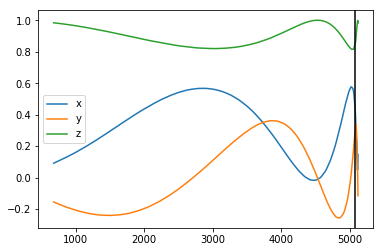

In [14]:
fig = plt.figure()
z_ax = h_coprec.frame*k*np.conjugate(h_coprec.frame)
plot_z = quaternion.as_float_array(z_ax[1000:-1150])[:,1:4]
rel_ts = h.t[1000:-1150] 
plt.plot(rel_ts, plot_z)
plt.legend(["x", "y", "z"])
plt.axvline(h.t[frame[0][0]], color="k")

0.054678136443726544

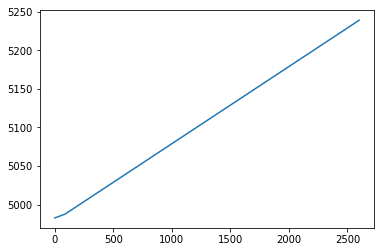

In [15]:
quaternion.as_float_array(h_corot.frame)[frame[0][0]-1500:, :]
plt.plot(h.t[14548:])
h.t[14548]-h.t[14547]


### 

In [16]:
im = sum((h_corot.frame)[frame[0][0]-600:]*quaternion.z).imag
im/norm(im)

array([-0.01012495,  0.12247675, -0.99241974])

(-1, 1)

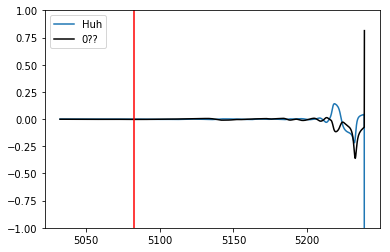

In [17]:
i = quaternion.quaternion(0,1,0,0)
j = quaternion.quaternion(0,0,1,0)
k = quaternion.quaternion(0,0,0,1)
m = 2
n = 1
def cross(a,b):
    return 1/2*(a*b - b*a)
max = frame[0][0]
t = h.t
dt = (t - np.roll(t,1))
q =h_coprec.frame
q_dot = (np.roll(q,-1) - q)/dt
q_dot[0] = q_dot[1]
eye = np.array([i,j,k])

plt.plot(t[max - 500:], quaternion.as_float_array(q_dot*i*1/q - q*i*1/q**2*q_dot)[max-500:][:,m])
plt.plot(t[max - 500:], -quaternion.as_float_array(q_dot*j*1/q - q*j*1/q**2*q_dot)[max-500:][:,n], "k")
plt.legend(["Huh", "0??" , r"(-)$\omega_z$", r"(-)$\omega_x$"])
plt.axvline(h.t[max], color="r")
plt.ylim(-1,1)

(0, 0.1)

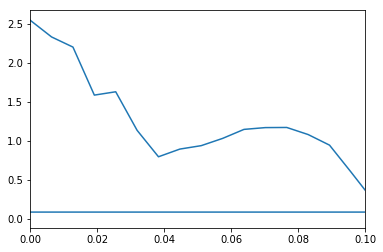

In [18]:
fig = plt.figure()
freqs= np.fft.fftfreq(len(quaternion.as_float_array(-q_dot*j*1/q + q*j*1/q*1/q*q_dot)[frame[0][0]:][:,1]))
plt.plot(10*freqs, .1*abs(np.fft.fft(quaternion.as_float_array(-q_dot*j*1/q + q*j*1/q*1/q*q_dot)[frame[0][0]:][:,1])))
plt.xlim(0, .1)

In [19]:

# It's weird that the angular velocity of the corotating frame is like .04 - .05 M, this is not even close to what I would expect 

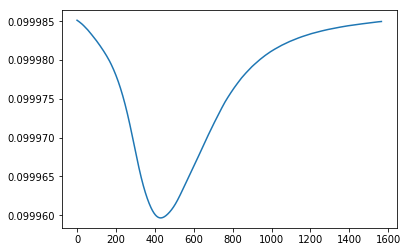

In [20]:
plt.plot((t - np.roll(t,1))[frame[0][0]:])

---
# BMS Transformation

In [21]:
q*q_dot - q_dot*q

array([quaternion(0, 1.25707797113109e-05, -0.000156067716475424, -7.56522780704252e-05),
       quaternion(0, 1.25879124109033e-05, -0.000156065888179173, -7.56524007104301e-05),
       quaternion(0, -2.35722111363557e-05, 0.000292224339195729, 0.000150614028802485),
       ...,
       quaternion(0, 0.0630179681005335, -0.0759365750311679, 0.0933589861827711),
       quaternion(0, 0.0628793889180468, -0.075871556828796, 0.0931110776794494),
       quaternion(0, -0.531517399517032, 6.59885136121985, 1.87020708204964)],
      dtype=quaternion)

The documentation for a transformation can be found by calling `help(scri.WaveformGrid.from_modes)`

In [22]:
help(scri.WaveformGrid.from_modes)

Help on method from_modes in module scri.waveform_grid:

from_modes(w_modes, **kwargs) method of builtins.type instance
    Construct grid object from modes, with optional BMS transformation
    
    This "constructor" is designed with the goal of transforming the frame in which the modes are measured.  If
    this is not desired, it can be called without those parameters.
    
    It is important to note that the input transformation parameters are applied in the order listed in the
    parameter list below:
      1. (Super)Translations
      2. Rotation (about the origin of the translated system)
      3. Boost
    All input parameters refer to the transformation required to take the mode's inertial frame onto the inertial
    frame of the grid's inertial observers.  In what follows, the inertial frame of the modes will be unprimed,
    while the inertial frame of the grid will be primed.
    
    The translations (space, time, spacetime, or super) can be given in various ways, which

Let's start with a simple rotation. We'll create a quaternion to describe the rotation of the frame that we wish to perform.

In [23]:
i = quaternion.quaternion(0,1,0,0)
j = quaternion.quaternion(0,0,1,0)
k = quaternion.quaternion(0,0,0,1)
def cross(a,b):
    return 1/2*(a*b - b*a)

In [24]:
i = quaternion.quaternion(0,1,0,0)
j = quaternion.quaternion(0,0,1,0)
k = quaternion.quaternion(0,0,0,1)
def cross(a,b):
    return 1/2*(a*b - b*a)
k_hat = quaternion.quaternion(0, 0.25269634778, 0.04202266793, 0.80968828452)
k_hat = k_hat/ np.sqrt(k_hat*np.conjugate(k_hat))
ax = cross(k, k_hat)
ax = ax/np.sqrt(ax*np.conjugate(ax))
cos_al = np.real(k*np.conjugate(k_hat))
alpha = np.arccos(cos_al)
ax.imag

array([-0.16404426,  0.98645298,  0.        ])

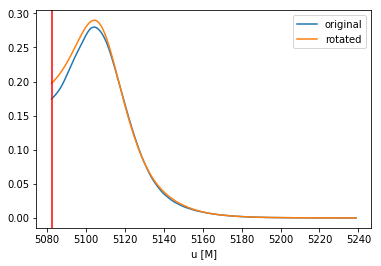

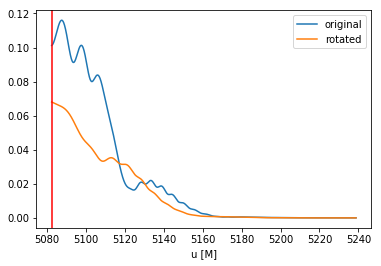

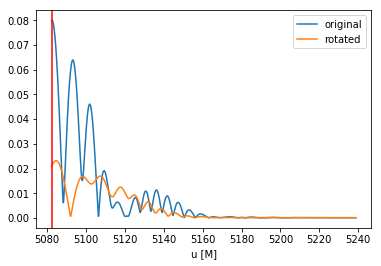

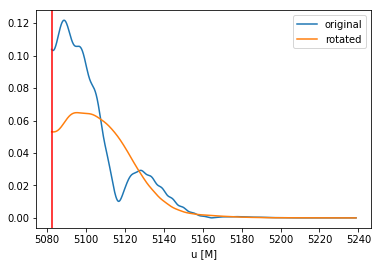

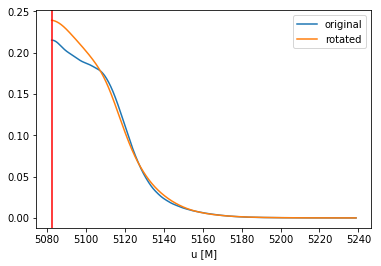

In [25]:
eps = 1
r = quaternion.quaternion(np.cos(eps*0.5*alpha), *np.sin(eps*0.5*alpha)*ax.imag)
gamma = .1
r_mod = quaternion.quaternion(np.cos(gamma), 0, 0, np.sin(gamma))*r
# r = h_coprec.frame[14010]
rotation_axis = np.array([0, 1.0, 0]) # rotation about the y-axis
rotation_axis /= np.linalg.norm(rotation_axis) # make sure its a unit vector

theta = np.pi/4 # rotation angle
#rotor = np.array([r_mod.real, r_mod.imag)
rotor = np.concatenate([np.array([r_mod.real]),r_mod.imag ])
#q = quaternion.quaternion(0,np.pi/2,0,0)
#rotor = np.concatenate([np.array([q.real]),q.imag ])
Yl2m2= np.transpose(np.stack([h.t, np.real(h.data[:, lm(l, m, h.ell_min)]),
	                                  np.imag(h.data[:, lm(l, m, h.ell_min)])]))
h_rot = h.transform(frame_rotation = rotor)
l, m = 2, 2

Yl2m2_rot = np.transpose(np.stack([h_rot.t, np.real(h_rot.data[:, lm(l, m, h.ell_min)]),
	                                  np.imag(h_rot.data[:, lm(l, m, h.ell_min)])]))
for i in range(-2,3):
    l, m = 2,i
    plt.plot(h.t[max_frame:], np.abs(h.data[:, lm(l, m, h.ell_min)][max_frame:]), label="original")
    plt.plot(h_rot.t[max_frame:], np.abs(h_rot.data[:, lm(l, m, h.ell_min)][max_frame:]), label="rotated")
    plt.xlabel("u [M]")
    plt.legend()
    plt.axvline(h.t[max_frame], color="r")
    plt.show()

In [26]:
Yl2m2[:,1:]-Yl2m2_rot[:,1:]


array([[-7.88736943e-04, -1.69557867e-04],
       [-7.67834973e-04, -1.84381039e-04],
       [-7.49132682e-04, -2.07046495e-04],
       ...,
       [ 4.25093309e-06,  7.46420131e-06],
       [ 4.57213824e-06,  7.16693298e-06],
       [ 4.87184482e-06,  6.85117250e-06]])

0.0010147640592768352
signal shape is (2, 1000)
 noise shape is (2, 1000)
Fitting starting at time 5088.342302689892 M
Peak Strain is around 5082.343233016646 M
Fitting until 5188.3147637559905 M
a is fit as  0.44404184114274736
M is fit as 0.9999999999999999


 active_mask: array([ 0,  0,  0,  0,  0,  0,  1, -1, -1,  0,  0,  1,  0,  0,  0,  1])
        cost: 22261.868445175263
         fun: array([ 4.44102913, -6.53488758, -0.92038988, ...,  0.9949598 ,
        1.00232041,  1.12166213])
        grad: array([ 2.12805677e-02, -2.19616381e-02, -1.69241109e-04, -1.66378231e-04,
       -4.51063399e-05,  7.97143925e-05, -4.34782141e+00,  1.03418168e+01,
        7.71286349e-01, -1.15833702e-04,  4.37789961e-05, -2.30910041e+00,
        3.32187690e-06,  3.94965909e-07, -6.67352575e-01, -4.04207913e+04])
         jac: array([[ 1.00759624e+01,  0.00000000e+00,  1.00759630e+01, ...,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-4.20664791e+01,  1.89381188e+00, -4.13337941e+01, ...,
         1.05966466e+00, -1.25470662e+00, -6.16638249e+00],
       [-3.10967419e+01,  2.80562095e+00, -3.00277029e+01, ...,
         1.39651730e+00, -3.69090103e-01, -6.55764688e+00],
       ...,
       [-1.22983009e-03, -1.04365498e-03, -0.00000000e+0

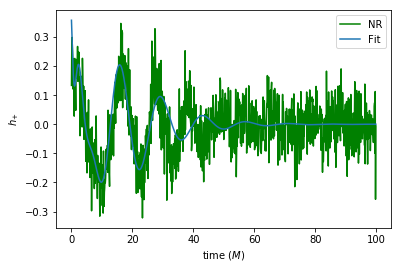

<Figure size 432x288 with 0 Axes>

In [32]:
fit_qnm_modes_to_signal("/Users/isaaclegred/qnm-fitting/GetData/SXS_BBH_1975",
                        Yl2m2, -60, 1000, include_noise=True)



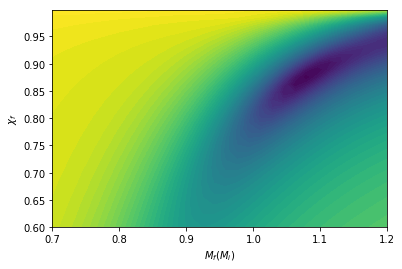

In [41]:
PlotCosts.plot_minimal_costs(Yl2m2, offset=-60, num_steps=1000, a_bounds=[.6,.999], M_bounds=[.7, 1.2])

We can also apply a boost, or a spacetime translation, or both at the same time!

In [ ]:
h_trans = h.transform(boost_velocity=[0,0,0.01], spacetime_translation=[-20., 5, -4.4, 8])

In [ ]:
l, m = 2, 2
plt.plot(h.t, np.real(h.data[:, lm(l, m, h.ell_min)]), label="original")
plt.plot(h_trans.t, np.real(h_trans.data[:, lm(l, m, h_trans.ell_min)]), label="Lorentz transformed")
plt.xlabel("u [M]")
plt.legend()
plt.show()

There are many other operations that can be performed on a `WaveformModes` object so read the documentation and explore!

In [ ]:
?scri.rotate_decomposition_basis

In [119]:
?minimize_given_mass_and_spin

In [42]:
%matplotlib inline

In [ ]:
max

In [ ]:
ang_vel = quaternion.angular_velocity(q, t)[max-2000:-700]
plt.plot(t[max-2000:-700], ang_vel)
plt.legend(["x", "y", "z"])
plt.axvline(h.t[max], color="r")

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D(ang_vel[:,0], ang_vel[:,1], ang_vel[:,2], "r")

In [ ]:
v = np.array([0.02, 0.04, 0.30])
def norm(v) : return np.sqrt(sum(v**2))
v/norm(v)

In [ ]:
 np.array([0.0322649379349, 0.120815865436, 0.782947749347])/norm(np.array([0.0322649379349, 0.120815865436, 0.782947749347]))

In [ ]:
poss_spin = ang_vel[1200+865,:]

In [ ]:
poss_spin/norm(poss_spin)

In [ ]:
# So an answer to the question of "Does the spin of the black hole really go to zero in the coprecessing frame?" Seems to 
# be yes, since the case of 0305 showed that the spin is fit to as small a value as 10^-13, at the same time though,
# the mass increases dramatically.  In the case of 1975, however, the spin, after conversion to the co-rotating frame
# was fit to the correct value for the actual remnant black hole (or very near to it .81 fit vs .85 actual)

In [ ]:
norm(np.array([0.25269634778, 0.04202266793, 0.80968828452]))

In [57]:
sp_eigenvector = h.LLDominantEigenvector()[1000:-1000]


array([1., 1., 1., ..., 1., 1., 1.])

In [47]:


def Get_lines(configs, body_index, times):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    dims = 3
    lineData = np.empty((dims, len(times)))
    line_data = []

    return lineData

def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, 0:num])
        line.set_3d_properties(data[2, 0 : num])
        
    return lines

In [71]:
# Attaching 3D axis to the figure
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = p3.Axes3D(fig)


data = [-np.transpose(sp_eigenvector)]
# draw sphere
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wire_frame(x, y, z, color="g")
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], "k") [0] for dat in data]


# Setting the axes properties
ax.set_xlim3d([-1, 1])
ax.set_xlabel('X')

ax.set_ylim3d([-1, 1])
ax.set_ylabel('Y')

ax.set_zlim3d([-1, 1])
ax.set_zlabel('Z')

ax.set_title('Precession Z-axis ')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 20*np.arange(len(sp_eigenvector)//20), fargs=(data, lines),
                                   interval=1000, blit=False)
line_ani.save('Before_instability_1975_eigs.mp4', fps=50)
plt.show()

SyntaxError: invalid syntax (<ipython-input-71-2f4895b4d227>, line 13)

In [81]:
max

13813

In [83]:
clear(max)

In [84]:
max

13813

In [86]:
del max

In [104]:
np.array([k,k]).imag

array([quaternion(0, 0, 0, 0), quaternion(0, 0, 0, 0)], dtype=quaternion)

In [62]:
v =  np.sum(plot_z[:-1000,:],0)
v/norm(v)

array([0.07297575, 0.1445053 , 0.98680938])

In [118]:
h.

2

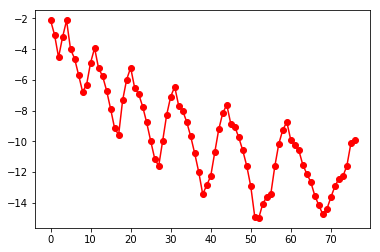

In [152]:
plt.plot(np.log(abs(h.data[12000])), "-ro")

In [204]:
import os


<module 'os' from '/usr/local/anaconda3/lib/python3.7/os.py'>

In [212]:
os.("LoadPython.sh")


AttributeError: module 'os' has no attribute 'os'

In [2]:
import SetupData
import SetupTrial

In [8]:
ls

ConfidenceIntervals.png     PlotCosts.py
FitCoeffsLinear.py          PrecessingFit.py
FitMassAndSpin.png          __pycache__/
FitWithLigoNoise.py         deprecated/
GWConfidenceIntervals.png   example.sh
GWFitMassAndSpin.png        infer_params_from_freqs.py
GWMinimumCostsManda.png


In [30]:
#del fit_qnm_modes_to_signal
from FitWithLigoNoise import fit_qnm_modes_to_signal


In [40]:
import importlib
importlib.reload(PlotCosts)

<module 'PlotCosts' from '/Users/isaaclegred/qnm-fitting/bin/PlotCosts.py'>

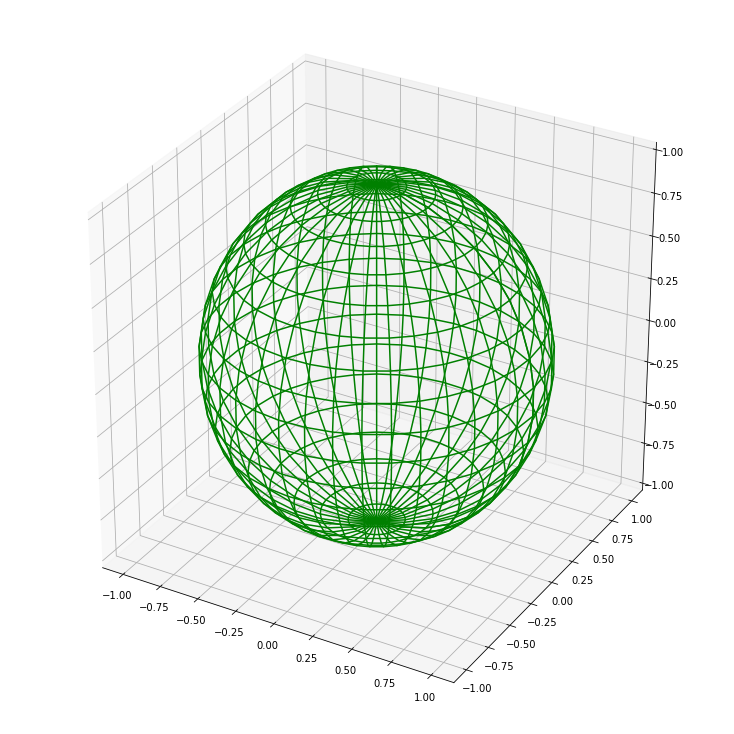

In [69]:
# NOTE: Can't pass empty arrays into 3d version of plot()
# draw sphere
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = p3.Axes3D(fig)
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="g", cmap='binary')
plt.show()

In [131]:
?plot_minimal_costs

In [28]:
cd bin

/Users/isaaclegred/qnm-fitting/bin
